## 1. Imports

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.preprocessing import RobustScaler
#from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import shap
from catboost import CatBoostClassifier
import optuna

## 2. Load and Explore Dataset


In [9]:
train_data=pd.read_csv('dataset/train.csv')
test_data=pd.read_csv('dataset/test.csv')

In [10]:
print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)

Train shape: (165034, 14)
Test shape: (110023, 13)


In [11]:
train_data.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [12]:
test_data.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


1. **Total Records**: 165,034 rows.
2. **Columns**: 14 columns in total.
   - **Integer columns**: 6 columns (e.g., `id`, `CustomerId`, `CreditScore`, `Tenure`, `NumOfProducts`, `Exited`).
   - **Float columns**: 5 columns (e.g., `Age`, `Balance`, `HasCrCard`, `IsActiveMember`, `EstimatedSalary`).
   - **Object columns**: 3 columns (e.g., `Surname`, `Geography`, `Gender`).
3. **Data Completeness**: All columns are fully populated (no missing values).
4. **Data Types**: 
   - `int64`: 6 columns (integer-based values).
   - `float64`: 5 columns (floating-point numerical values).
   - `object`: 3 columns (text/string-based values).
5. **Key Columns**:
   - `Exited`: Binary outcome variable (likely indicating customer churn).
   - `Age`, `Balance`, `EstimatedSalary`: Continuous numerical features.
   - `Geography`, `Gender`: Categorical variables.

## 3. Data Cleaning

In [14]:
print(f'Missing values: {train_data.isna().sum().sum()}')
print(f'Duplicated values: {train_data.duplicated().sum()}')

print(f'Missing values: {test_data.isna().sum().sum()}')
print(f'Duplicated values: {test_data.duplicated().sum()}')

Missing values: 0
Duplicated values: 0
Missing values: 0
Duplicated values: 0


## 4. Exploratory Data Analysis 

## 4.1 Univariate Analysis

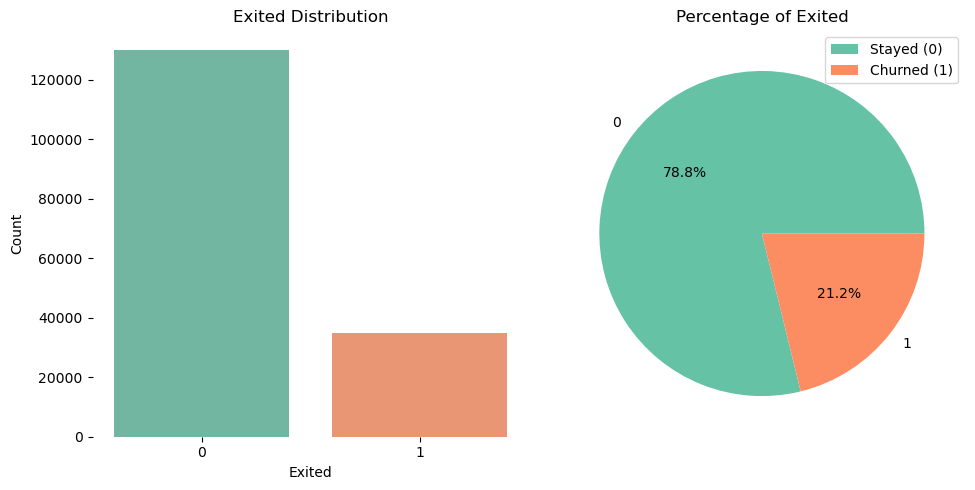

In [25]:

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot bar chart for 'Exited' distribution
sns.countplot(x='Exited', data=train_data, ax=axes[0], palette='Set2')
axes[0].set_title('Exited Distribution')
axes[0].set_ylabel('Count')

# Plot pie chart for 'Exited' percentage distribution
exited_percentage = train_data['Exited'].value_counts(normalize=True) * 100
axes[1].pie(exited_percentage, labels=exited_percentage.index, autopct='%1.1f%%', colors=sns.color_palette('Set2'))
axes[1].set_title('Percentage of Exited')
sns.despine(left=True, bottom=True)

# Show the plots
plt.legend(['Stayed (0)', 'Churned (1)'])
plt.tight_layout()
plt.show()


**Insights from the visualizations:**
  - The majority of customers did **not churn** (Exited = 0).
  - A smaller proportion, around **21%**, churned (Exited = 1).
  - **79.0%** of customers stayed with the company.
  - **21.0%** of customers churned.

This confirms an **imbalance** in the dataset, where non-churned customers significantly outnumber churned customers. 

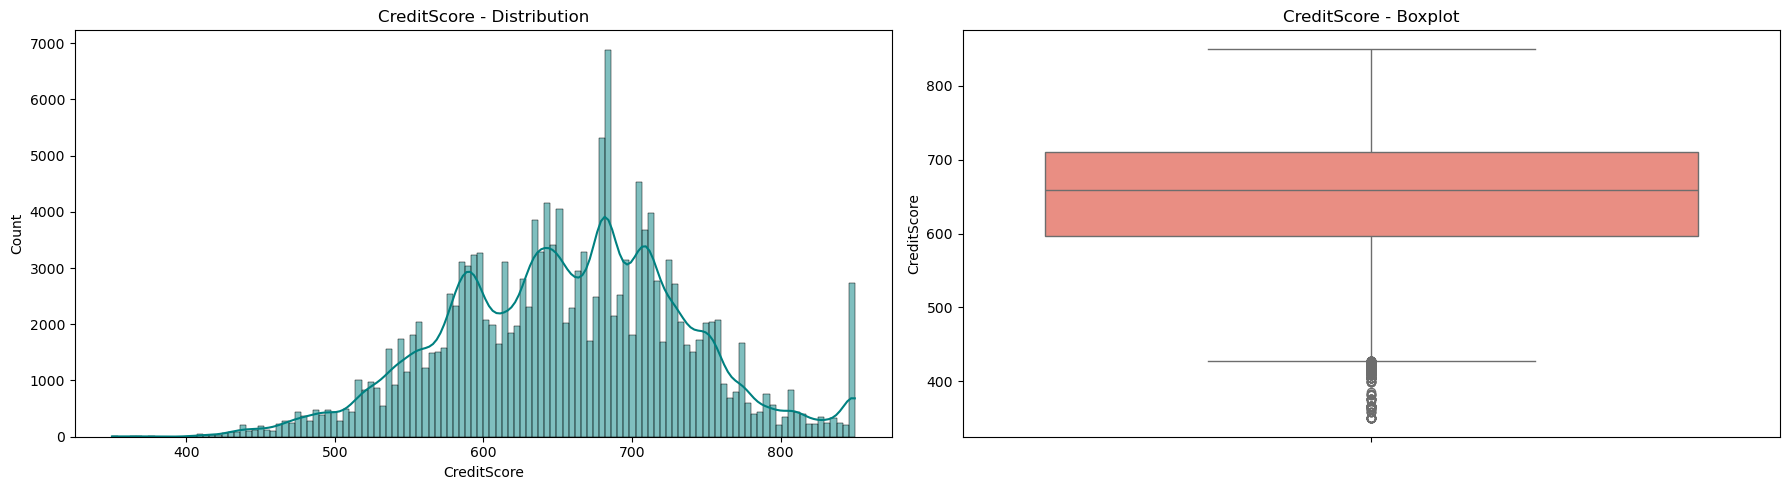

In [30]:
# Create the plots for 'CreditScore'
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.histplot(train_data['CreditScore'], kde=True, ax=axes[0], color='teal')
axes[0].set_title('CreditScore - Distribution')

sns.boxplot(y=train_data['CreditScore'], ax=axes[1], color='salmon')
axes[1].set_title('CreditScore - Boxplot')

plt.tight_layout()
plt.show()


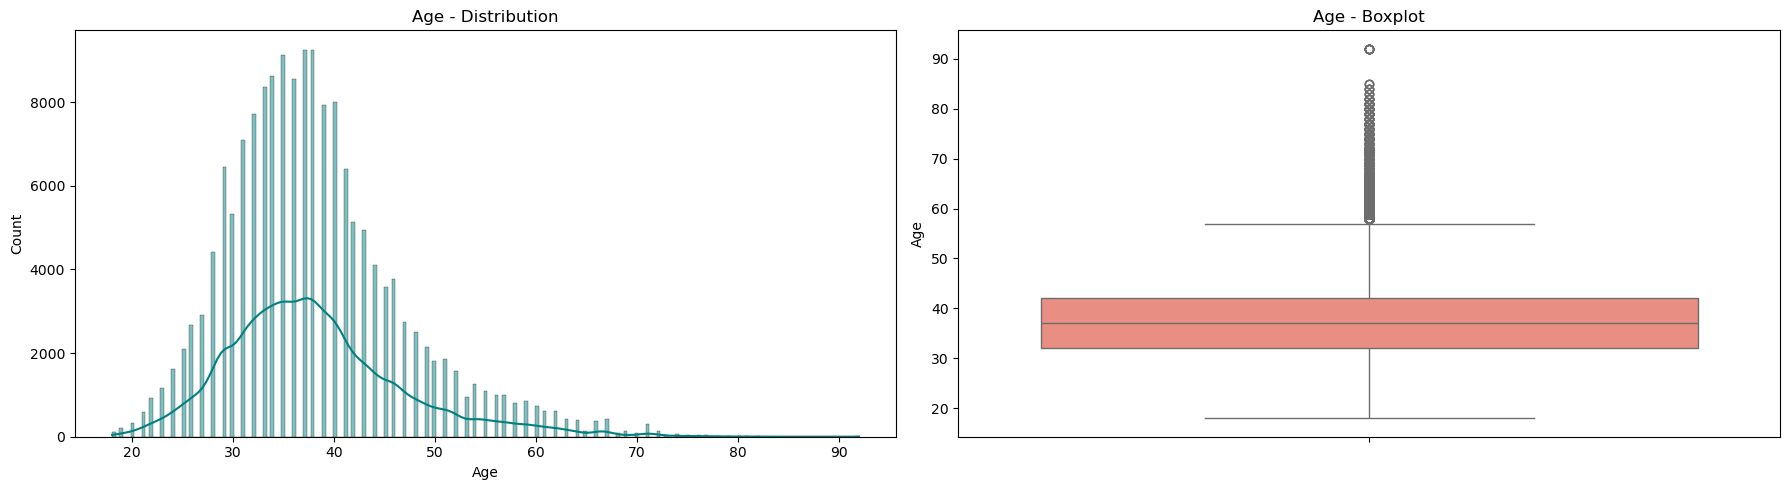

In [31]:
# Create the plots for 'Age'
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.histplot(train_data['Age'], kde=True, ax=axes[0], color='teal')
axes[0].set_title('Age - Distribution')

sns.boxplot(y=train_data['Age'], ax=axes[1], color='salmon')
axes[1].set_title('Age - Boxplot')

plt.tight_layout()
plt.show()

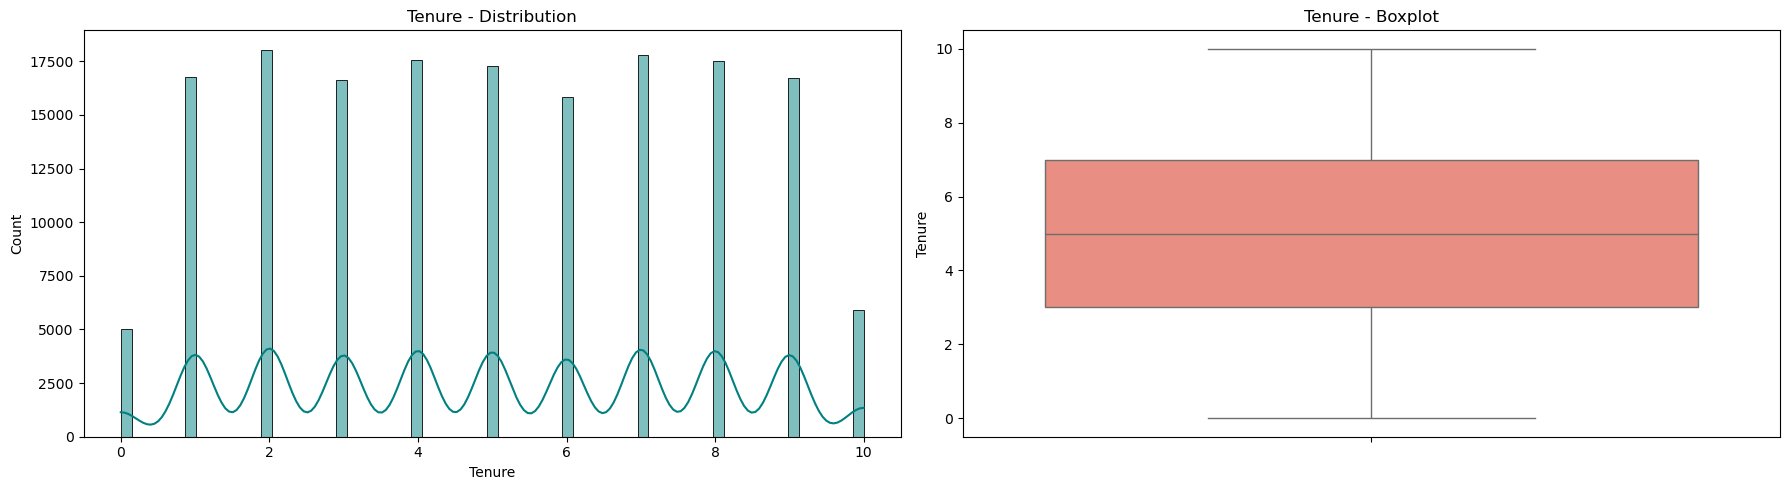

In [32]:
# Create the plots for 'Tenure'
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.histplot(train_data['Tenure'], kde=True, ax=axes[0], color='teal')
axes[0].set_title('Tenure - Distribution')

sns.boxplot(y=train_data['Tenure'], ax=axes[1], color='salmon')
axes[1].set_title('Tenure - Boxplot')

plt.tight_layout()
plt.show()


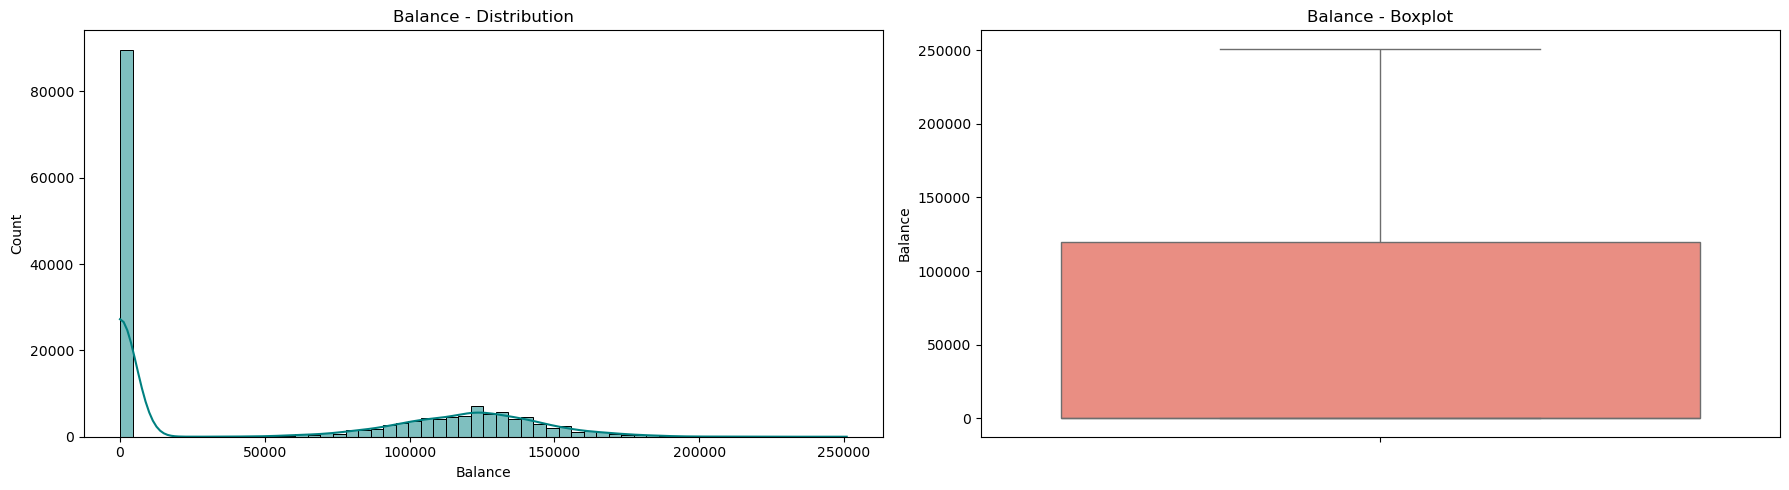

In [33]:
# Create the plots for 'Balance'
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.histplot(train_data['Balance'], kde=True, ax=axes[0], color='teal')
axes[0].set_title('Balance - Distribution')

sns.boxplot(y=train_data['Balance'], ax=axes[1], color='salmon')
axes[1].set_title('Balance - Boxplot')

plt.tight_layout()
plt.show()

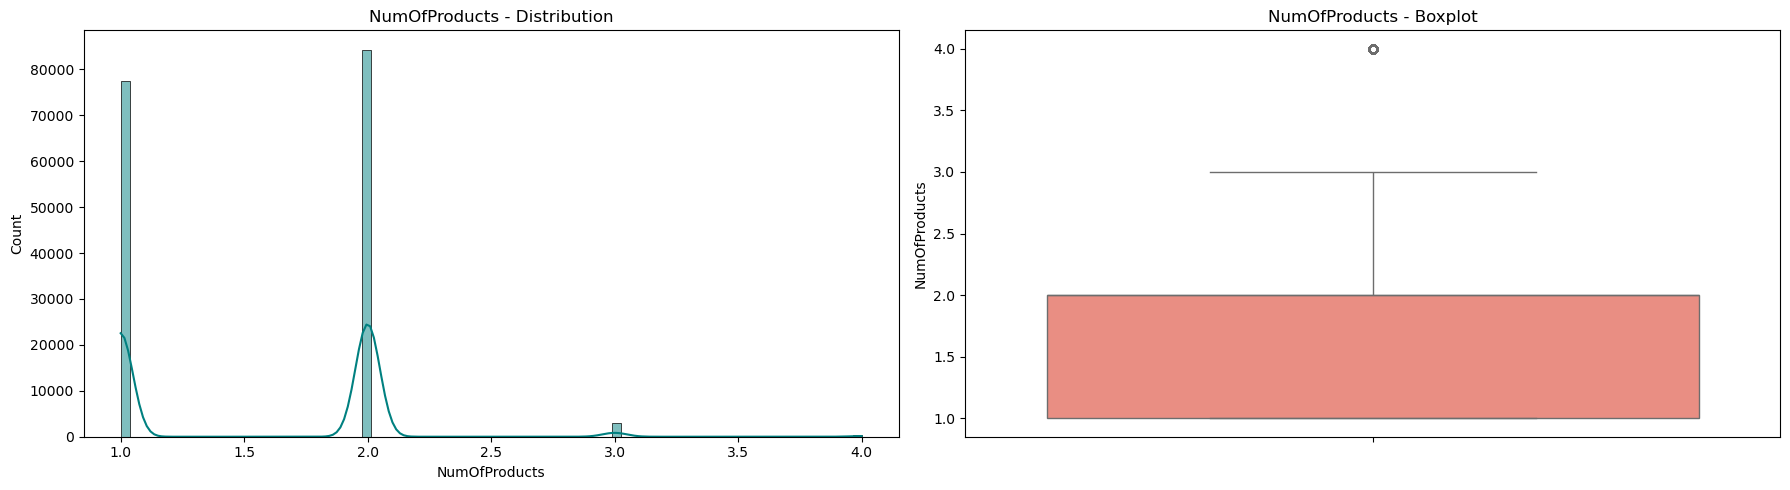

In [34]:
# Create the plots for 'NumOfProducts'
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.histplot(train_data['NumOfProducts'], kde=True, ax=axes[0], color='teal')
axes[0].set_title('NumOfProducts - Distribution')

sns.boxplot(y=train_data['NumOfProducts'], ax=axes[1], color='salmon')
axes[1].set_title('NumOfProducts - Boxplot')

plt.tight_layout()
plt.show()

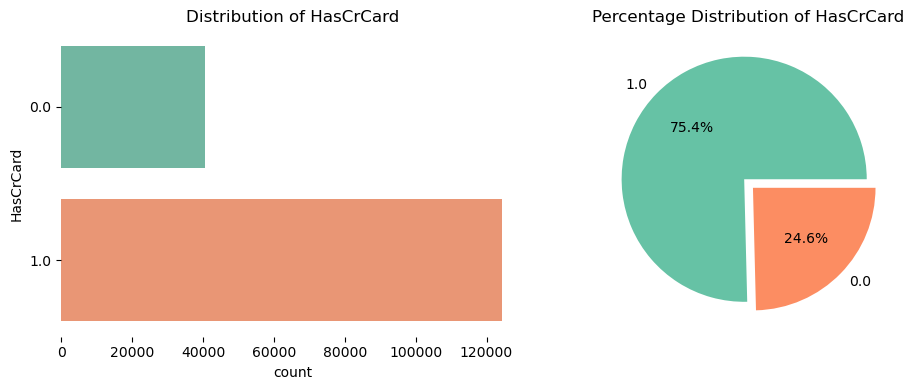

In [59]:
# Create the plots for 'HasCrCard'
plt.figure(figsize=(10, 4))

# Countplot for 'HasCrCard'
plt.subplot(1, 2, 1)
sns.countplot(y='HasCrCard', data=train_data, hue='HasCrCard', palette='Set2', legend=False)

plt.title('Distribution of HasCrCard')
sns.despine(left=True, bottom=True)

# Plot 2: Pie chart for 'HasCrCard' percentage distribution
plt.subplot(1, 2, 2)
train_data['HasCrCard'].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('Set2'), explode=[0.05,0.05])
plt.title('Percentage Distribution of HasCrCard')
plt.ylabel('')

plt.tight_layout()
plt.show()


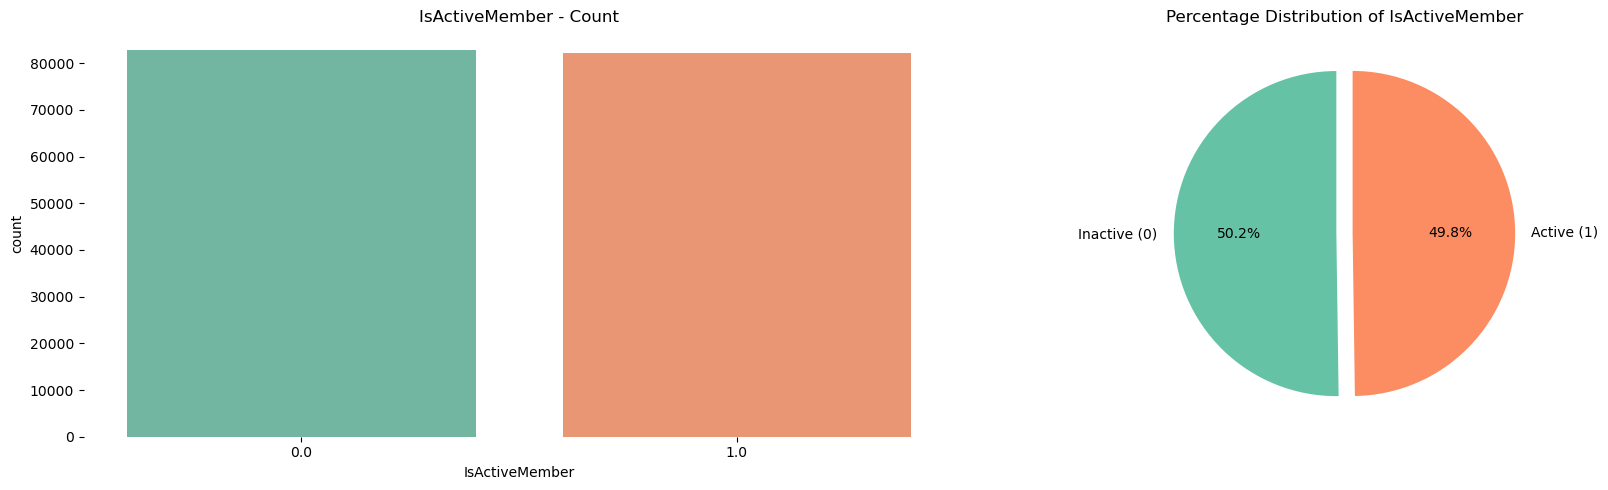

In [55]:
# Create the plots for 'IsActiveMember'
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.countplot(x='IsActiveMember', data=train_data, ax=axes[0], palette='Set2')
axes[0].set_title('IsActiveMember - Count')

axes[1].pie(train_data['IsActiveMember'].value_counts(), 
            labels=['Inactive (0)', 'Active (1)'], autopct='%1.1f%%', colors=sns.color_palette('Set2'), 
            startangle=90, explode=[0.05, 0.05])
axes[1].set_title('Percentage Distribution of IsActiveMember')

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


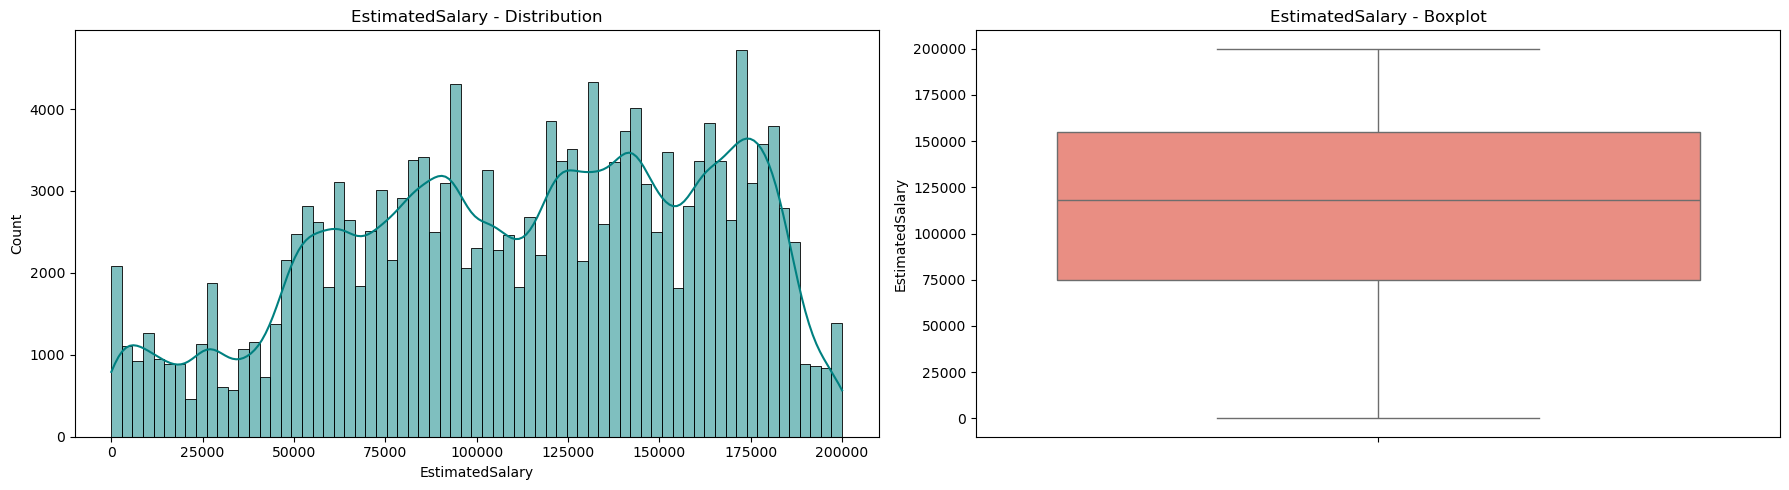

In [38]:
# Create the plots for 'EstimatedSalary'
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.histplot(train_data['EstimatedSalary'], kde=True, ax=axes[0], color='teal')
axes[0].set_title('EstimatedSalary - Distribution')

sns.boxplot(y=train_data['EstimatedSalary'], ax=axes[1], color='salmon')
axes[1].set_title('EstimatedSalary - Boxplot')

plt.tight_layout()
plt.show()

**Insights from the visualizations:**

1. **Credit Score**:
   - A normal-like distribution centered around 650.
   - Outliers are present on both ends of the distribution.

2. **Age**:
   - Most customers are between 30 and 40 years old.
   - A few customers are outliers aged above 80.

3. **Tenure**:
   - Tenure ranges from 0 to 10 years, with a uniform spread across values.

4. **Balance**:
   - Many customers have a balance of 0, indicating low account usage.
   - Some have significantly high balances, appearing as outliers.

5. **Number of Products**:
   - Most customers have either 1 or 2 products.
   - A small number have more than 2 products.

6. **Has Credit Card (Binary)**:
   - Around 75% of customers possess a credit card.

7. **Is Active Member (Binary)**:
   - The active and inactive members are distributed almost evenly.

8. **Estimated Salary**:
   - The salary distribution is fairly uniform, with no significant outliers.

In [39]:
train_data.describe()
# train_data.describe().T

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


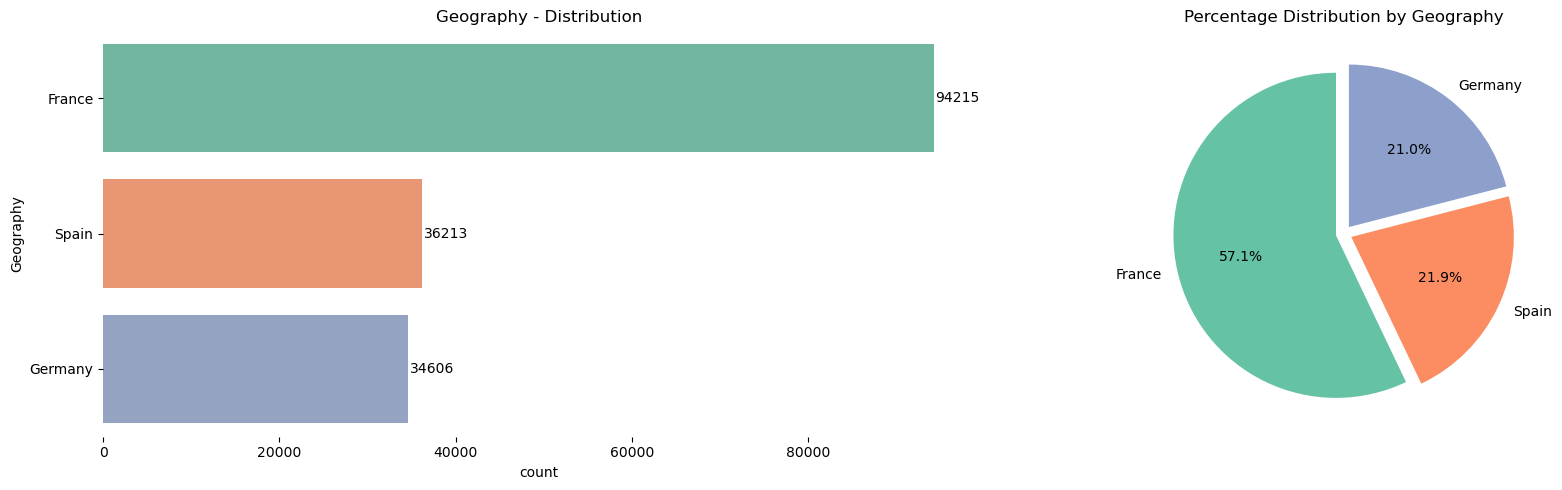

In [67]:
# Create the plots for 'Geography'
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.countplot(y='Geography', data=train_data, palette='Set2', ax=axes[0])
axes[0].set_title('Geography - Distribution')

# Annotate counts on the bars
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_width())}', 
                     (p.get_width(), p.get_y() + p.get_height() / 2), 
                     ha='center', va='center', xytext=(17, 0), textcoords='offset points')

sns.despine(left=True, bottom=True)

axes[1].pie(train_data['Geography'].value_counts(), 
            labels=train_data['Geography'].value_counts().index, 
            autopct='%1.1f%%', 
            colors=sns.color_palette('Set2'), 
            startangle=90, explode=[0.05]*train_data['Geography'].nunique())
axes[1].set_title('Percentage Distribution by Geography')

plt.tight_layout()
plt.show()

**Insights from the visualizations:**

### **Geography:**
- Most customers are from **France**, followed by **Germany** and **Spain**.
- **Percentage**:  
  - **France**: Majority of customers (~50%)  
  - **Germany**: ~25%  
  - **Spain**: ~25%

### **Gender:**
- The number of male and female customers is fairly balanced.
- **Percentage**:  
  - **Female**: ~51%  
  - **Male**: ~49%


## 4.2 Bivariate Analysis

In [35]:
# Create a crosstab of Geography and Exited
contingency_table = pd.crosstab(train_data['Geography'], train_data['Exited'])

# Display the crosstab
print(contingency_table)

Exited         0      1
Geography              
France     78643  15572
Germany    21492  13114
Spain      29978   6235


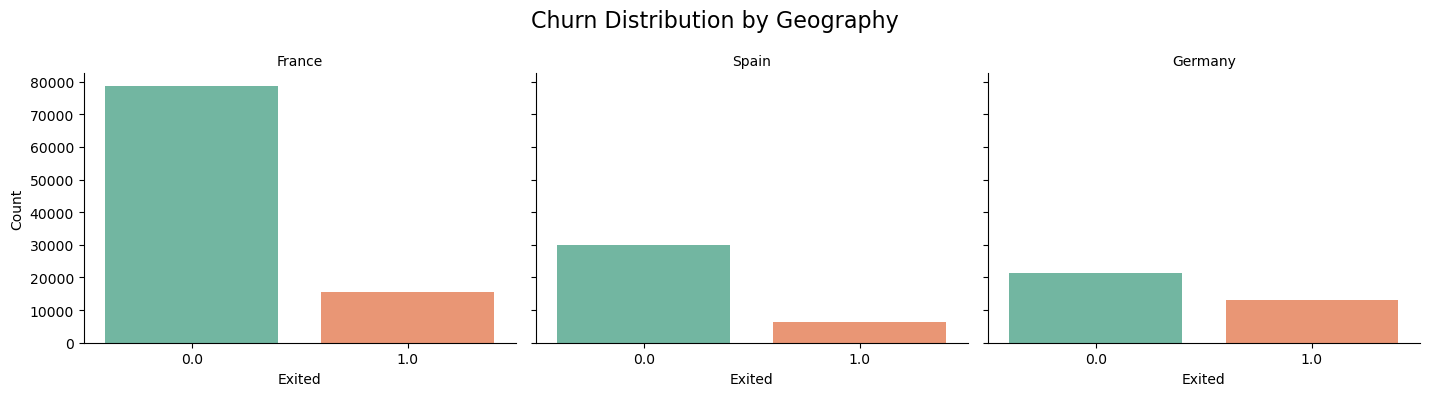

In [36]:
g = sns.FacetGrid(train_data, col='Geography', height=4, aspect=1.2)

# Pass data to countplot explicitly and assign hue to Exited
g.map(sns.countplot, 'Exited', data=train_data, hue='Exited', palette='Set2', legend=False)

g.set_titles("{col_name}")
g.set_axis_labels("Exited", "Count")
g.fig.suptitle('Churn Distribution by Geography', fontsize=16)
plt.tight_layout()
plt.show()


In [37]:
# Create a crosstab of Gender and Exited
contingency_table = pd.crosstab(train_data['Gender'], train_data['Exited'])

# Display the crosstab
print(contingency_table)

Exited      0      1
Gender              
Female  51779  20105
Male    78334  14816


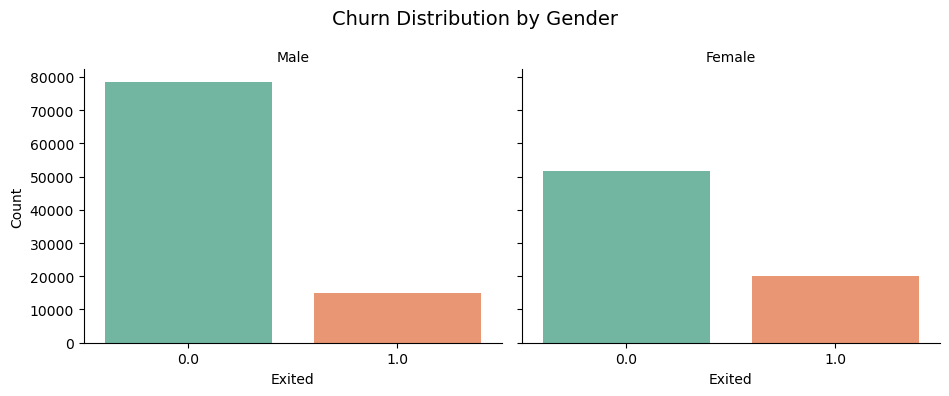

In [38]:
# Create a FacetGrid to visualize Gender by Exited
g = sns.FacetGrid(train_data, col='Gender', height=4, aspect=1.2)

g.map(sns.countplot, 'Exited', data=train_data, hue='Exited', palette='Set2', legend=False)
g.set_titles("{col_name}")
g.set_axis_labels("Exited", "Count")
g.fig.suptitle('Churn Distribution by Gender', fontsize=14)
plt.tight_layout()
plt.show()

**Insights:**

**Geography vs. Exited:**
  - **Germany** has a relatively higher proportion of churn compared to Spain and France.
  - **France** has the most customers, but the churn proportion seems lower compared to Germany.

**Gender vs. Exited:**
  - The **churn rate is higher among females** compared to males.
  - Even though there are slightly fewer female customers, they have a higher tendency to churn.

This analysis suggests that **geography** and **gender** are important features to consider in predicting churn. Germany and female customers might need focused strategies to reduce churn.

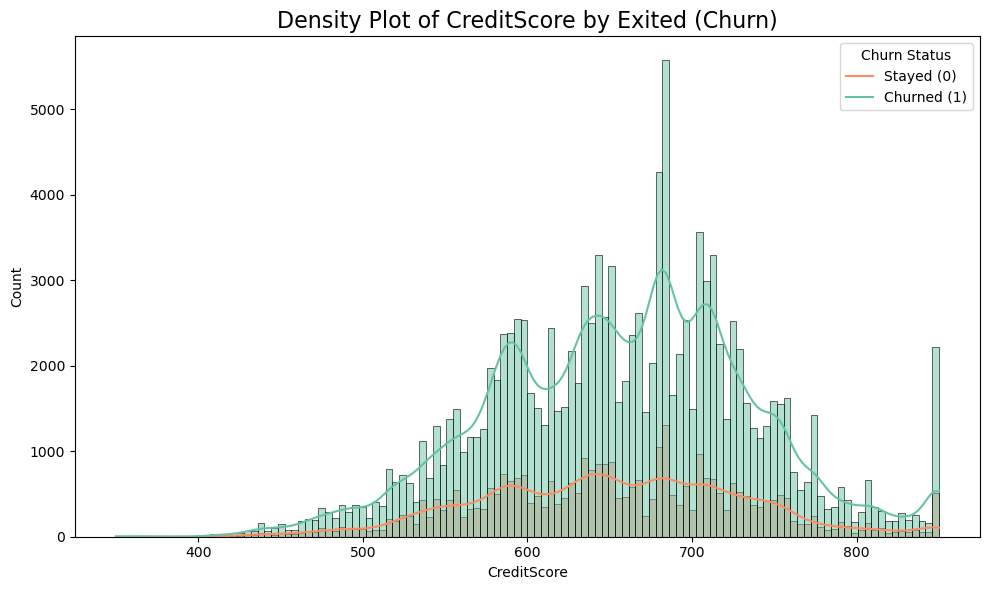

In [39]:
# Create a histplot for CreditScore by Exited
plt.figure(figsize=(10, 6))
sns.histplot(data=train_data, x='CreditScore', hue='Exited', kde=True, fill=True, palette='Set2')
plt.title('Density Plot of CreditScore by Exited (Churn)', fontsize=16)
plt.xlabel('CreditScore')
plt.ylabel('Count')
plt.legend(title='Churn Status', labels=['Stayed (0)', 'Churned (1)'])
plt.tight_layout()
plt.show()

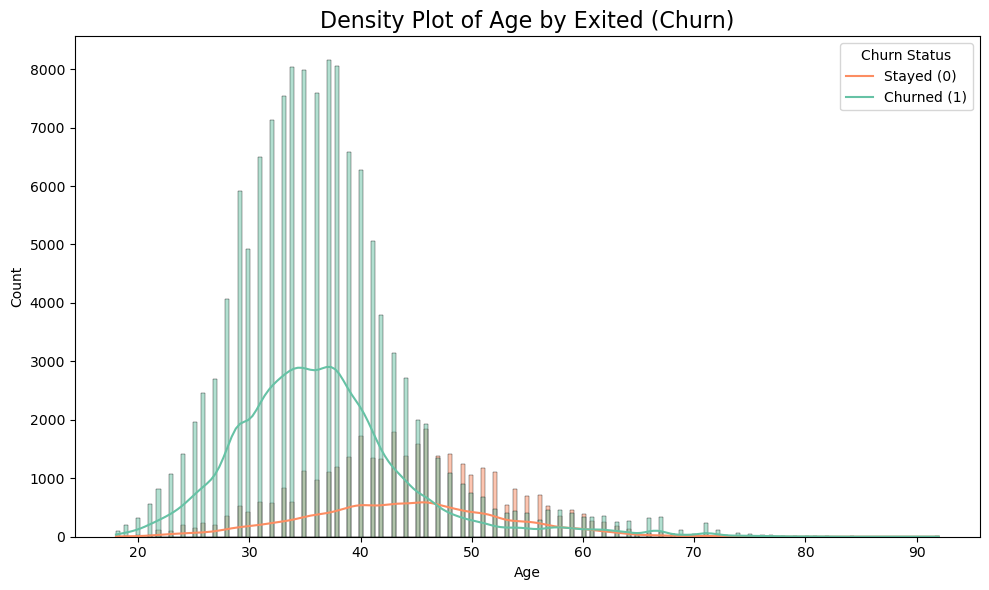

In [40]:
# Create a histplot for Age by Exited
plt.figure(figsize=(10, 6))
sns.histplot(data=train_data, x='Age', hue='Exited', kde=True, fill=True, palette='Set2')
plt.title('Density Plot of Age by Exited (Churn)', fontsize=16)
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Churn Status', labels=['Stayed (0)', 'Churned (1)'])
plt.tight_layout()
plt.show()

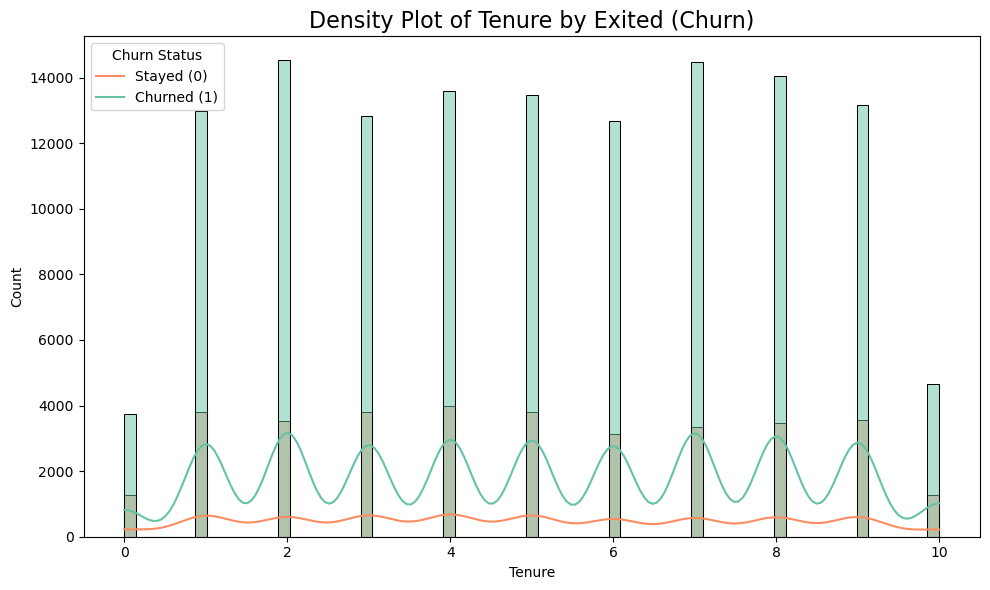

In [41]:
# Create a histplot for Tenure by Exited
plt.figure(figsize=(10, 6))
sns.histplot(data=train_data, x='Tenure', hue='Exited', kde=True, fill=True, palette='Set2')
plt.title('Density Plot of Tenure by Exited (Churn)', fontsize=16)
plt.xlabel('Tenure')
plt.ylabel('Count')
plt.legend(title='Churn Status', labels=['Stayed (0)', 'Churned (1)'])
plt.tight_layout()
plt.show()

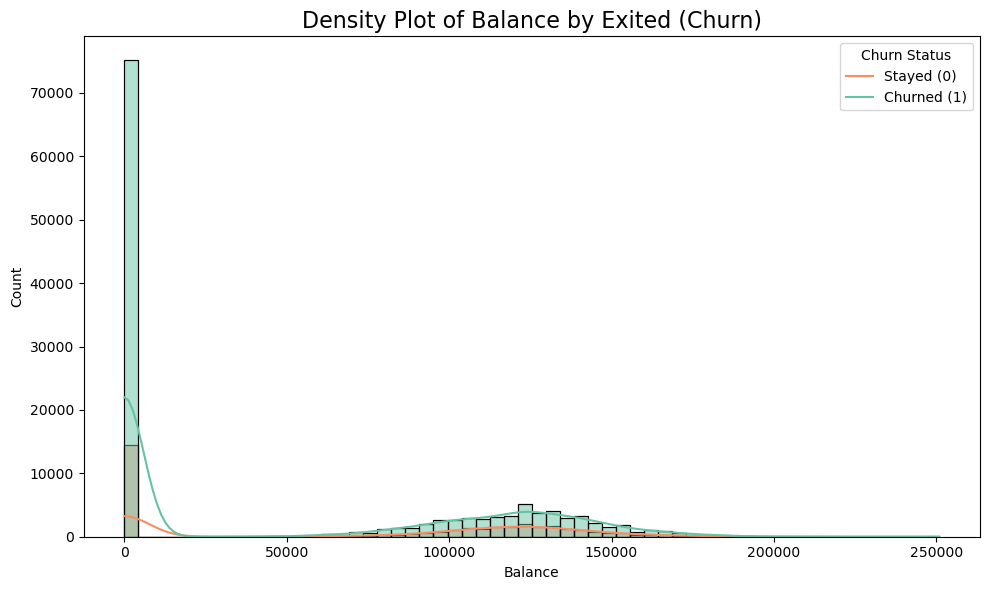

In [42]:
# Create a histplot for Balance by Exited
plt.figure(figsize=(10, 6))
sns.histplot(data=train_data, x='Balance', hue='Exited', kde=True, fill=True, palette='Set2')
plt.title('Density Plot of Balance by Exited (Churn)', fontsize=16)
plt.xlabel('Balance')
plt.ylabel('Count')
plt.legend(title='Churn Status', labels=['Stayed (0)', 'Churned (1)'])
plt.tight_layout()
plt.show()

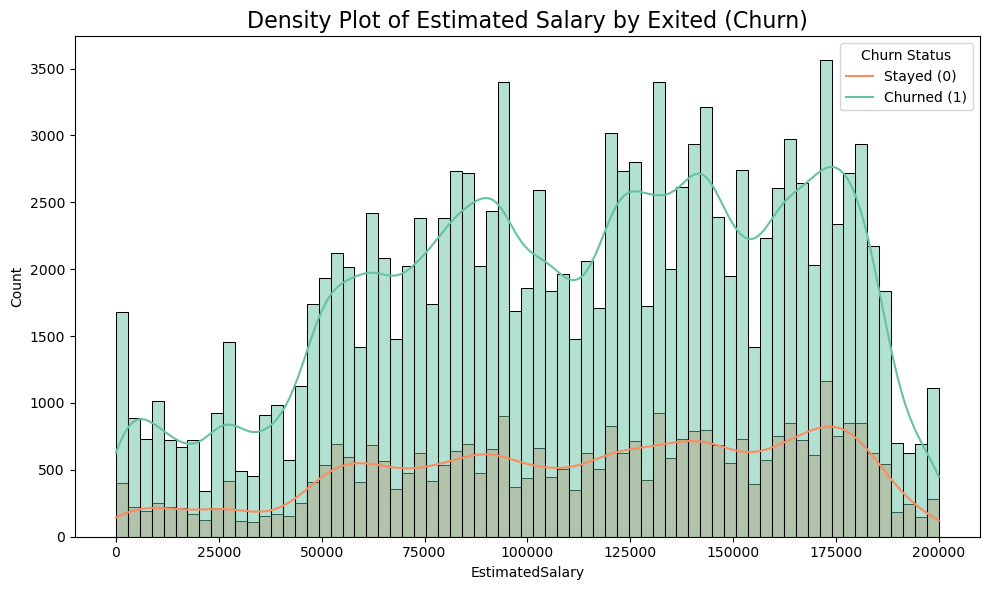

In [43]:
# Create a histplot for EstimatedSalary by Exited
plt.figure(figsize=(10, 6))
sns.histplot(data=train_data, x='EstimatedSalary', hue='Exited', kde=True, fill=True, palette='Set2')
plt.title('Density Plot of Estimated Salary by Exited (Churn)', fontsize=16)
plt.xlabel('EstimatedSalary')
plt.ylabel('Count')
plt.legend(title='Churn Status', labels=['Stayed (0)', 'Churned (1)'])
plt.tight_layout()
plt.show()

**Insights from the visualizations:**

1. **CreditScore vs. Exited:**
   - Churned customers tend to have slightly lower credit scores compared to those who stayed.
   - There is a noticeable concentration of churn around credit scores below 650.

2. **Age vs. Exited:**
   - Older customers, especially those aged above 40, show a higher tendency to churn.
   - Younger customers (under 30) are less likely to churn.

3. **Tenure vs. Exited:**
   - The tenure distribution is relatively even across both churned and non-churned customers.
   - Churn is slightly higher for customers with shorter tenures (below 5 years).

4. **Balance vs. Exited:**
   - Customers with either zero balance or very high balances tend to churn more.
   - Those with moderate balances appear to churn less frequently.

5. **Estimated Salary vs. Exited:**
   - Salary does not show a strong pattern with churn, suggesting it might not be a significant predictor.
   - Both churned and non-churned customers are evenly distributed across all salary levels.

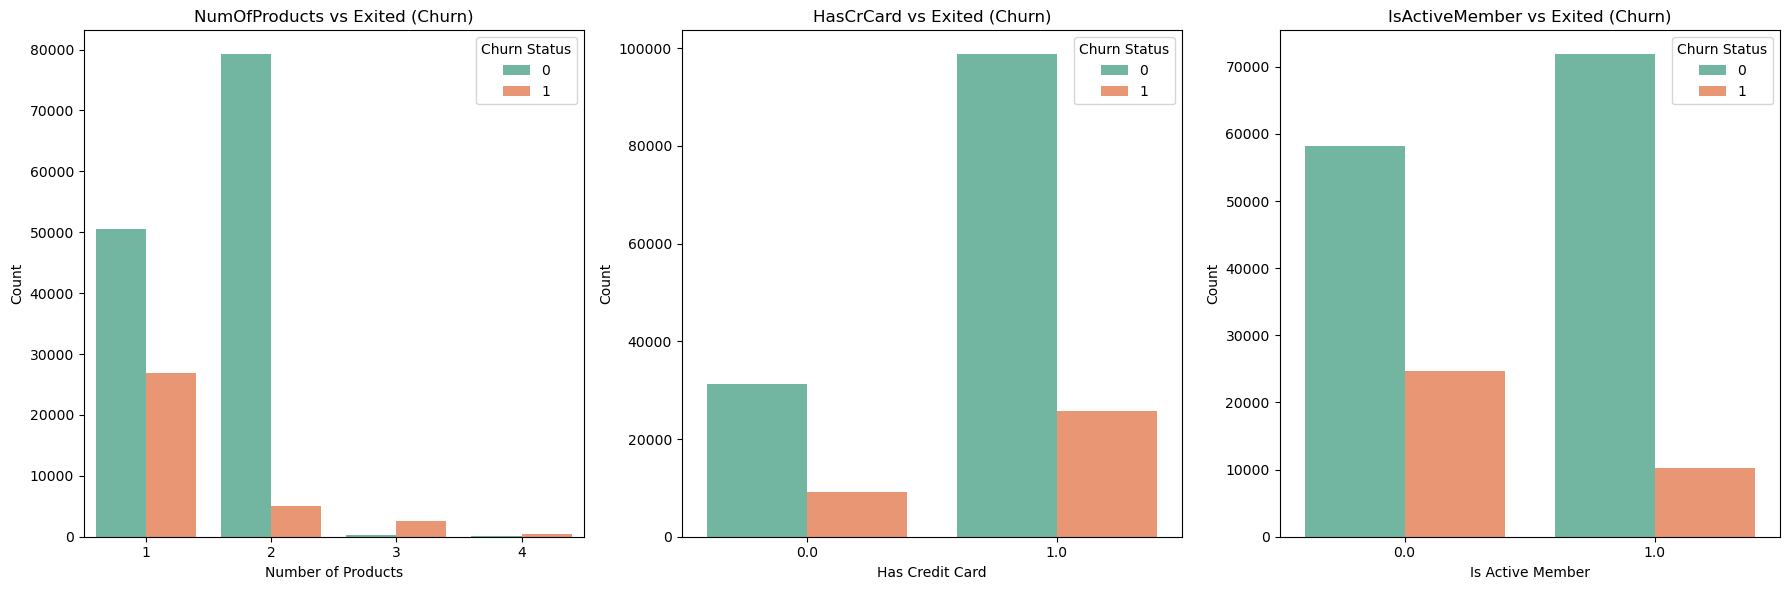

In [44]:
plt.figure(figsize=(18, 6))
    
# Countplot for NumOfProducts vs Exited
plt.subplot(1, 3, 1)
sns.countplot(data=train_data, x='NumOfProducts', hue='Exited', palette='Set2')
plt.title('NumOfProducts vs Exited (Churn)')
plt.xlabel('Number of Products')
plt.ylabel('Count')
plt.legend(title='Churn Status')

# Countplot for HasCrCard vs Exited
plt.subplot(1, 3, 2)
sns.countplot(data=train_data, x='HasCrCard', hue='Exited', palette='Set2')
plt.title('HasCrCard vs Exited (Churn)')
plt.xlabel('Has Credit Card')
plt.ylabel('Count')
plt.legend(title='Churn Status')

# Countplot for IsActiveMember vs Exited
plt.subplot(1, 3, 3)
sns.countplot(data=train_data, x='IsActiveMember', hue='Exited', palette='Set2')
plt.title('IsActiveMember vs Exited (Churn)')
plt.xlabel('Is Active Member')
plt.ylabel('Count')
plt.legend(title='Churn Status')

plt.tight_layout()
plt.show()

**Insights from the visualizations:**

1. **Number of Products vs. Exited:**
   - Customers with **1 or 2 products** are more likely to stay, while those with **3 or more products** show a higher churn rate.
   - Having **4 products** corresponds to a high likelihood of churn, suggesting that managing multiple products may lead to dissatisfaction or complexity.

2. **Has Credit Card vs. Exited:**
   - Churn rates are similar regardless of whether a customer has a credit card, indicating that this feature may have limited predictive value.
   - Customers with or without credit cards churn at comparable rates.

3. **Is Active Member vs. Exited:**
   - **Active members** are far less likely to churn compared to inactive members.
   - This suggests that engagement plays a key role in customer retention, making this a strong predictor for churn.


## 4.3 Multivariate Analysis

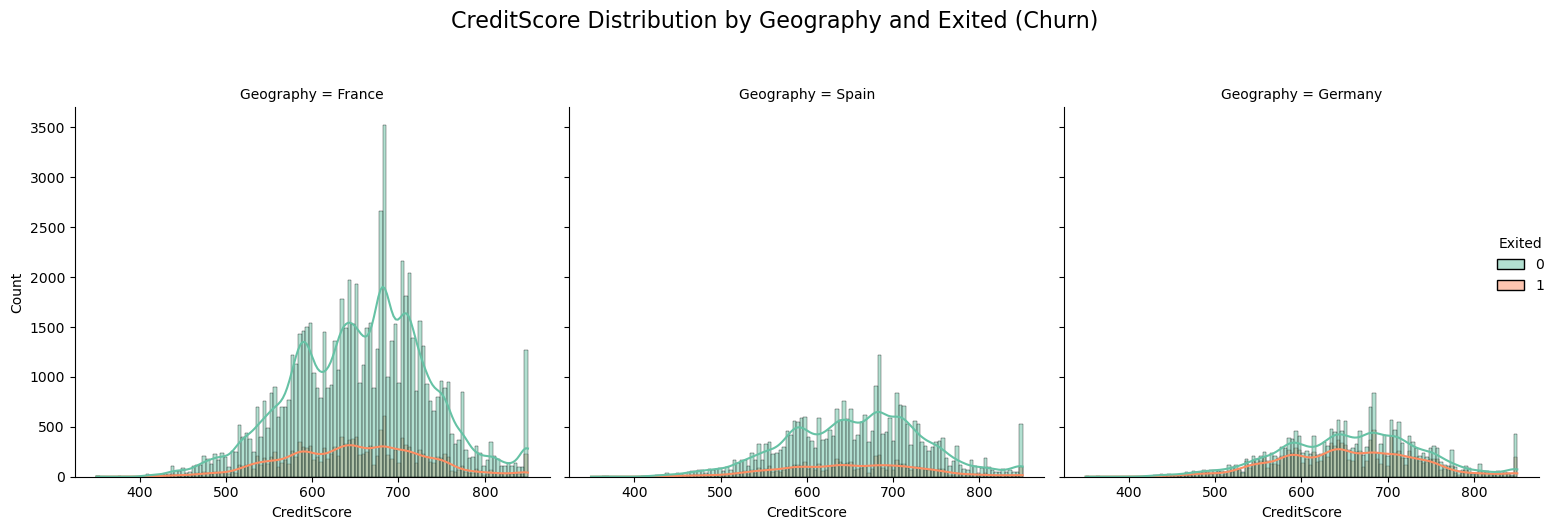

In [45]:
# Create the displot
g = sns.displot(data=train_data, x="CreditScore", col="Geography", hue="Exited", kde=True, palette='Set2')
g.fig.suptitle('CreditScore Distribution by Geography and Exited (Churn)', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

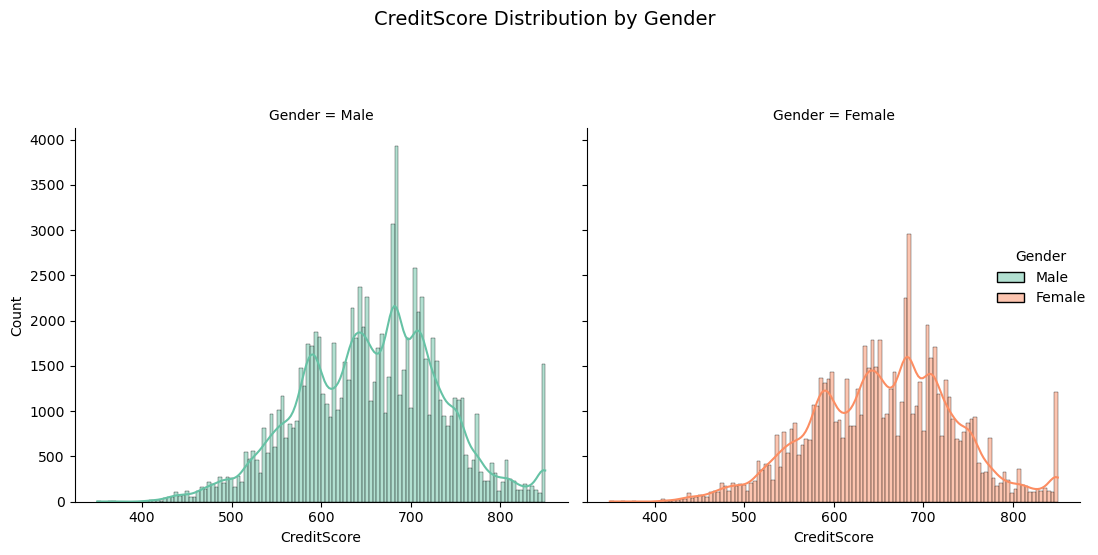

In [46]:
# Create the displot
g = sns.displot(data=train_data, x="CreditScore", col="Gender", hue="Gender", kde=True, palette='Set2')
g.fig.suptitle('CreditScore Distribution by Gender', fontsize=14, y=1.10)
plt.tight_layout()
plt.show()

**Insights from the CreditScore Distribution by Geography, Gender, and Churn**

1. **CreditScore Distribution by Geography and Exited:**
   - **France**: The distribution of CreditScore is fairly even between churned and non-churned customers. However, churn seems slightly more common for scores below 650.
   - **Germany**: A higher proportion of churn is observed, especially among customers with CreditScores below 600.
   - **Spain**: The distribution resembles France, though churn is slightly less frequent, especially for scores above 700.

2. **CreditScore Distribution by Gender:**
   - Both **males and females** show similar distributions of CreditScore, with most scores clustering around 600 to 700.
   - No significant difference between genders is observed in terms of CreditScore distribution.

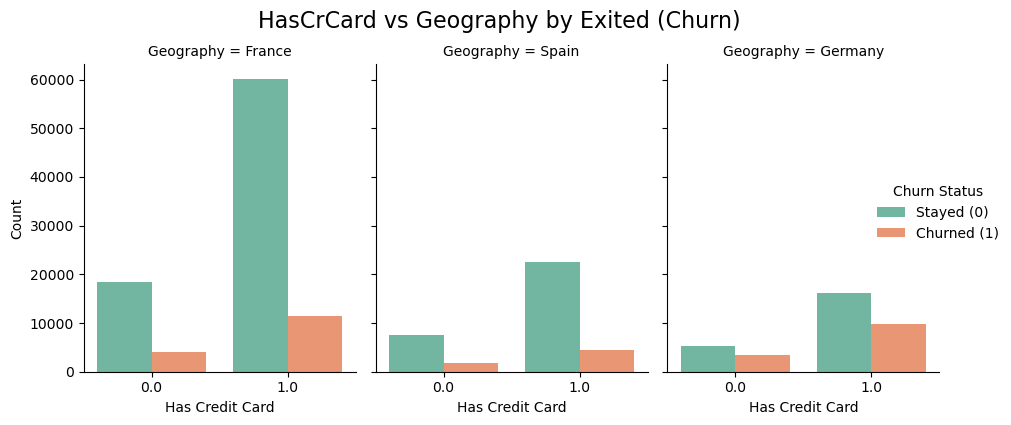

In [47]:
# Create a catplot to visualize HasCrCard vs Geography by Exited
g = sns.catplot(
    data=train_data, 
    x='HasCrCard', 
    hue='Exited', 
    col='Geography', 
    kind='count',
    palette='Set2',
    height=4, 
    aspect=0.8
)

g.fig.suptitle('HasCrCard vs Geography by Exited (Churn)', fontsize=16, y=1.05)
g.set_axis_labels('Has Credit Card', 'Count')
g._legend.set_title('Churn Status')
new_labels = ['Stayed (0)', 'Churned (1)']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
plt.show()

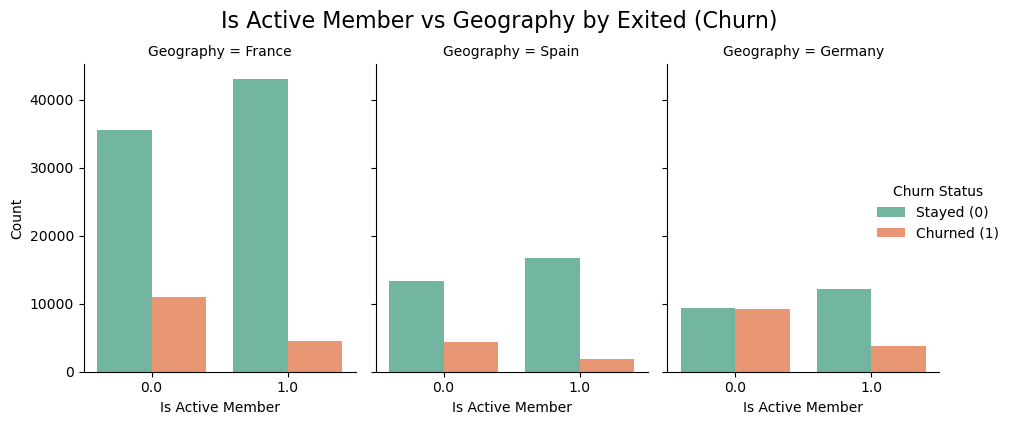

In [48]:
# Create a catplot to visualize IsActiveMember vs Geography by Exited
g = sns.catplot(
    data=train_data, 
    x='IsActiveMember', 
    hue='Exited', 
    col='Geography', 
    kind='count',
    palette='Set2',
    height=4, 
    aspect=0.8
)

g.fig.suptitle('Is Active Member vs Geography by Exited (Churn)', fontsize=16, y=1.05)
g.set_axis_labels('Is Active Member', 'Count')
g._legend.set_title('Churn Status')
new_labels = ['Stayed (0)', 'Churned (1)']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
plt.show()

**Insights from the visualizations:**

HasCrCard vs Geography by Exited (Churn):
- **France and Spain**: Having a credit card or not doesn’t seem to have a significant impact on churn; the distributions look similar.
- **Germany**: There is a slightly higher churn rate among customers without a credit card, suggesting that credit card ownership may have some influence on customer retention.

IsActiveMember vs Geography by Exited (Churn):
- **Active members** have significantly lower churn rates across all regions (France, Germany, and Spain).
- **Inactive members** show much higher churn rates, indicating that customer engagement plays a crucial role in retention.
- **Germany** has the most pronounced difference in churn between active and inactive members.

## 5. Feature Engineering

Feature Creation:

* Balance_to_Age_Ratio: The ratio of balance to age to capture wealth across different age groups.
* Products_per_Year: The average number of products held per year to gauge product engagement.

In [49]:
# Balance_to_Age_Ratio and Products_per_Year
train_data['Balance_to_Age_Ratio'] = train_data['Balance'] / (train_data['Age'] + 1e-5)
train_data['Products_per_Year'] = train_data['NumOfProducts'] / (train_data['Tenure'] + 1e-5)

test_data['Balance_to_Age_Ratio'] = test_data['Balance'] / (test_data['Age'] + 1e-5)
test_data['Products_per_Year'] = test_data['NumOfProducts'] / (test_data['Tenure'] + 1e-5)


In [50]:
# Display the updated columns
print("After feature creation columns in train_data:\n", train_data.columns)
print("After feature creation columns in test_data:\n", test_data.columns)


After feature creation columns in train_data:
 Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'Balance_to_Age_Ratio',
       'Products_per_Year'],
      dtype='object')
After feature creation columns in test_data:
 Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Balance_to_Age_Ratio',
       'Products_per_Year'],
      dtype='object')


## 6. Data Preprocessing

In [51]:
# Drop irrelevant columns: 'id', 'CustomerId', 'Surname'
train_data = train_data.drop(['id', 'CustomerId', 'Surname'], axis=1)
test_data = test_data.drop(['id', 'CustomerId', 'Surname'], axis=1)


***RowNumber, CustomerId, and Surname:*** These features are identifiers and do not influence churn prediction, so they can be ignored

In [52]:
# Display the columns after dropping irrelevant ones
print("\nAfter dropping irrelevant columns in train_data:\n", train_data.columns)
print("After dropping irrelevant columns in test_data:\n", test_data.columns)



After dropping irrelevant columns in train_data:
 Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited', 'Balance_to_Age_Ratio', 'Products_per_Year'],
      dtype='object')
After dropping irrelevant columns in test_data:
 Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Balance_to_Age_Ratio', 'Products_per_Year'],
      dtype='object')


In [53]:
# One-Hot Encoding for 'Geography'
train_data_encoded = pd.get_dummies(train_data, columns=['Geography'])
test_data_encoded = pd.get_dummies(test_data, columns=['Geography'])

# Binary Encoding for 'Gender'
train_data_encoded['Gender'] = train_data_encoded['Gender'].map({'Male': 0, 'Female': 1})
test_data_encoded['Gender'] = test_data_encoded['Gender'].map({'Male': 0, 'Female': 1})

# Display the first few rows of the encoded train data
train_data_encoded.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Balance_to_Age_Ratio,Products_per_Year,Geography_France,Geography_Germany,Geography_Spain
0,668,0,33.0,3,0.00,2,1.0,0.0,181449.97,0,0.000000,0.666664,True,False,False
1,627,0,33.0,1,0.00,2,1.0,1.0,49503.50,0,0.000000,1.999980,True,False,False
2,678,0,40.0,10,0.00,2,1.0,0.0,184866.69,0,0.000000,0.200000,True,False,False
3,581,0,34.0,2,148882.54,1,1.0,1.0,84560.88,0,4378.896947,0.499998,True,False,False
4,716,0,33.0,5,0.00,2,1.0,1.0,15068.83,0,0.000000,0.399999,False,False,True


7. Correlation Heatmap

In [54]:
correlation_matrix = train_data_encoded.corr()
correlation_matrix

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Balance_to_Age_Ratio,Products_per_Year,Geography_France,Geography_Germany,Geography_Spain
CreditScore,1.000000,-0.002310,-0.008918,0.000942,0.006973,0.011361,-0.002828,0.014790,-0.001820,-0.027383,0.007451,0.001685,-0.005669,0.002996,0.003833
Gender,-0.002310,1.000000,0.063139,-0.008767,0.014699,-0.026098,-0.006418,-0.033722,0.007778,0.146442,0.002806,0.004899,-0.026204,0.039465,-0.007480
Age,-0.008918,0.063139,1.000000,-0.010830,0.064318,-0.102195,-0.012111,0.003320,-0.005399,0.340768,-0.126874,0.001635,-0.066439,0.093138,-0.012157
Tenure,0.000942,-0.008767,-0.010830,1.000000,-0.009481,0.007335,0.005327,-0.005532,0.000971,-0.019565,-0.007174,-0.297087,0.002960,-0.007751,0.004085
Balance,0.006973,0.014699,0.064318,-0.009481,1.000000,-0.361033,-0.018584,-0.015073,0.008586,0.129743,0.955975,-0.004885,-0.332811,0.539208,-0.132364
NumOfProducts,0.011361,-0.026098,-0.102195,0.007335,-0.361033,1.000000,0.005482,0.039736,-0.004285,-0.214554,-0.342066,0.045664,0.063096,-0.103034,0.025889
HasCrCard,-0.002828,-0.006418,-0.012111,0.005327,-0.018584,0.005482,1.000000,-0.021034,0.004438,-0.022141,-0.016530,-0.011354,0.015839,-0.004988,-0.014037
IsActiveMember,0.014790,-0.033722,0.003320,-0.005532,-0.015073,0.039736,-0.021034,1.000000,-0.008080,-0.210237,-0.008058,-0.000315,0.017864,-0.036433,0.014473
EstimatedSalary,-0.001820,0.007778,-0.005399,0.000971,0.008586,-0.004285,0.004438,-0.008080,1.000000,0.018827,0.008983,0.003435,-0.002085,0.013298,-0.010587
Exited,-0.027383,0.146442,0.340768,-0.019565,0.129743,-0.214554,-0.022141,-0.210237,0.018827,1.000000,0.055687,0.003684,-0.130797,0.211054,-0.051175


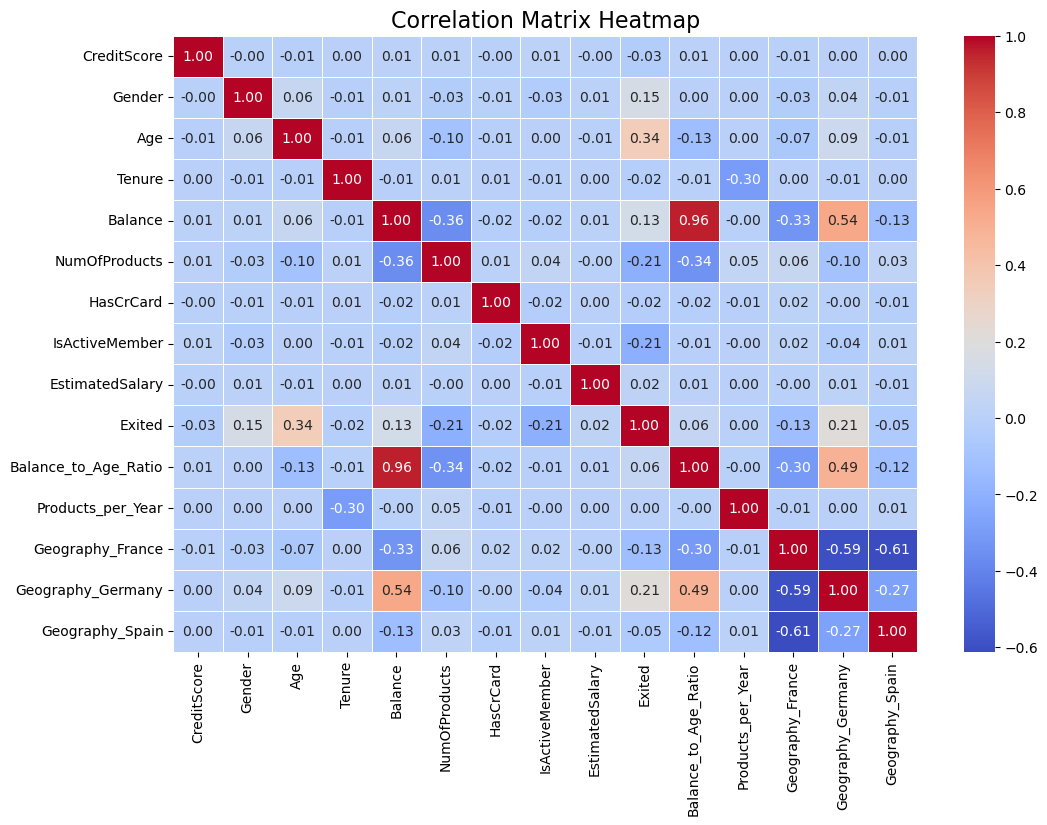

In [55]:
# Calculate the correlation matrix
correlation_matrix = train_data_encoded.corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.show()

8. Modeling

In [56]:
# Separate features and target from the train dataset
X = train_data_encoded.drop('Exited', axis=1)
y = train_data_encoded['Exited']

# Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
# Standardize the features
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_val = scaler.transform(X_val)

In [58]:
# Use RobustScaler to handle outliers
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [59]:
# Update models to handle class imbalance 
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    "XGBoost": xgb.XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(), 
                                  use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": lgb.LGBMClassifier(class_weight='balanced', verbosity=-1, random_state=42),
    "CatBoost": CatBoostClassifier(class_weights=[(y_train == 0).sum() / len(y_train), 
                                                  (y_train == 1).sum() / len(y_train)], 
                                   verbose=0, random_state=42)
}

In [60]:
# Train and evaluate each model
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1]

    accuracy = accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)
    report = classification_report(y_val, y_pred, output_dict=True)

    results[name] = {
        "Accuracy": accuracy,
        "AUC": auc,
        "Report": pd.DataFrame(report).T
    }

results_df = pd.DataFrame({
    name: {"Accuracy": results[name]["Accuracy"], "AUC": results[name]["AUC"]}
    for name in results
}).T

print("\nModel Evaluation Results:\n", results_df)

for name in results:
    print(f"\nClassification Report for {name}:\n")
    print(results[name]["Report"])

Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Training XGBoost...
Training LightGBM...
Training CatBoost...

Model Evaluation Results:
                      Accuracy       AUC
Logistic Regression  0.497167  0.444345
Decision Tree        0.801921  0.701176
Random Forest        0.857152  0.871857
XGBoost              0.815403  0.886631
LightGBM             0.814767  0.890734
CatBoost             0.845851  0.890922

Classification Report for Logistic Regression:

              precision    recall  f1-score       support
0              0.773725  0.512936  0.616901  26052.000000
1              0.193632  0.438102  0.268565   6955.000000
accuracy       0.497167  0.497167  0.497167      0.497167
macro avg      0.483679  0.475519  0.442733  33007.000000
weighted avg   0.651492  0.497167  0.543502  33007.000000

Classification Report for Decision Tree:

              precision    recall  f1-score       support
0              0.873917  0.875326  0.874621  260

In [61]:
# Re-split the data 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [62]:
# Use RobustScaler again
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

## Hyperparameter Tuning with Optuna

In [63]:
# Optuna objective function for RandomForest
def rf_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    y_prob = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_prob)
    return auc



In [64]:
# Optuna objective function for CatBoost
def catboost_objective(trial):
    depth = trial.suggest_int('depth', 4, 10)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 0.3, log=True)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1, 10)
    iterations = trial.suggest_int('iterations', 100, 500)

    model = CatBoostClassifier(
        depth=depth,
        learning_rate=learning_rate,
        l2_leaf_reg=l2_leaf_reg,
        iterations=iterations,
        class_weights=[(y_train == 0).sum() / len(y_train), (y_train == 1).sum() / len(y_train)],
        verbose=0,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_prob)
    return auc

In [65]:
# Run Optuna studies to find the best hyperparameters
print("Optimizing Random Forest...")
rf_study = optuna.create_study(direction='maximize')
rf_study.optimize(rf_objective, n_trials=20)

print(f"Best Random Forest AUC: {rf_study.best_value}")
print(f"Best Random Forest Hyperparameters: {rf_study.best_params}")

print("\nOptimizing CatBoost...")
catboost_study = optuna.create_study(direction='maximize')
catboost_study.optimize(catboost_objective, n_trials=20)

print(f"Best CatBoost AUC: {catboost_study.best_value}")
print(f"Best CatBoost Hyperparameters: {catboost_study.best_params}")

[I 2024-11-10 16:57:48,971] A new study created in memory with name: no-name-eef8be32-a24c-4a5d-9c3b-07977da5b6ff


Optimizing Random Forest...


[I 2024-11-10 16:57:53,345] Trial 0 finished with value: 0.8860448212682637 and parameters: {'n_estimators': 174, 'max_depth': 18, 'min_samples_split': 18, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8860448212682637.
[I 2024-11-10 16:58:00,140] Trial 1 finished with value: 0.8860455415000887 and parameters: {'n_estimators': 328, 'max_depth': 9, 'min_samples_split': 20, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.8860455415000887.
[I 2024-11-10 16:58:06,506] Trial 2 finished with value: 0.8799040336624764 and parameters: {'n_estimators': 346, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.8860455415000887.
[I 2024-11-10 16:58:15,913] Trial 3 finished with value: 0.8851021675059437 and parameters: {'n_estimators': 367, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.8860455415000887.
[I 2024-11-10 16:58:20,373] Trial 4 finished with value: 0.8831331861521662 and parameters:

Best Random Forest AUC: 0.8876108453336097
Best Random Forest Hyperparameters: {'n_estimators': 491, 'max_depth': 12, 'min_samples_split': 15, 'min_samples_leaf': 3}

Optimizing CatBoost...


[I 2024-11-10 17:00:34,864] Trial 0 finished with value: 0.8908437645529601 and parameters: {'depth': 6, 'learning_rate': 0.039664598263360135, 'l2_leaf_reg': 6.7744649017245155, 'iterations': 375}. Best is trial 0 with value: 0.8908437645529601.
[I 2024-11-10 17:00:36,698] Trial 1 finished with value: 0.8901972557677323 and parameters: {'depth': 7, 'learning_rate': 0.07483464753622583, 'l2_leaf_reg': 9.58463539459224, 'iterations': 147}. Best is trial 0 with value: 0.8908437645529601.
[I 2024-11-10 17:00:46,045] Trial 2 finished with value: 0.8908666491603421 and parameters: {'depth': 8, 'learning_rate': 0.023348969242215918, 'l2_leaf_reg': 1.8890518405060486, 'iterations': 451}. Best is trial 2 with value: 0.8908666491603421.
[I 2024-11-10 17:00:47,769] Trial 3 finished with value: 0.8806565903750758 and parameters: {'depth': 9, 'learning_rate': 0.0010472812093847855, 'l2_leaf_reg': 8.43027859950568, 'iterations': 101}. Best is trial 2 with value: 0.8908666491603421.
[I 2024-11-10 17

Best CatBoost AUC: 0.8912727053772784
Best CatBoost Hyperparameters: {'depth': 7, 'learning_rate': 0.1101712168867158, 'l2_leaf_reg': 8.483241781937958, 'iterations': 323}


## Train final models with the best hyperparameters from Optuna

In [66]:
# Use the best hyperparameters found by Optuna for RandomForest
best_rf_params = rf_study.best_params
best_rf = RandomForestClassifier(
    n_estimators=best_rf_params['n_estimators'],
    max_depth=best_rf_params['max_depth'],
    min_samples_split=best_rf_params['min_samples_split'],
    min_samples_leaf=best_rf_params['min_samples_leaf'],
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
best_rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=12,
                       min_samples_leaf=3, min_samples_split=15,
                       n_estimators=491, n_jobs=-1, random_state=42)

In [67]:
# Use the best hyperparameters found by Optuna for CatBoost
best_catboost_params = catboost_study.best_params
best_catboost = CatBoostClassifier(
    depth=best_catboost_params['depth'],
    learning_rate=best_catboost_params['learning_rate'],
    l2_leaf_reg=best_catboost_params['l2_leaf_reg'],
    iterations=best_catboost_params['iterations'],
    class_weights=[(y_train == 0).sum() / len(y_train), (y_train == 1).sum() / len(y_train)],
    verbose=0,
    random_state=42
)
best_catboost.fit(X_train, y_train)

In [76]:
# Evaluate both models on the validation set
def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1]
    accuracy = accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)
    report = classification_report(y_val, y_pred, output_dict=True)
    return accuracy, auc, pd.DataFrame(report).T

In [77]:
print("Evaluating the best Random Forest model...")
rf_accuracy, rf_auc, rf_report = evaluate_model(best_rf, X_val, y_val)
print(f"Random Forest - Accuracy: {rf_accuracy}, AUC: {rf_auc}\n")
print(rf_report)

Evaluating the best Random Forest model...
Random Forest - Accuracy: 0.8219468597570212, AUC: 0.8876108453336097

              precision    recall  f1-score       support
0              0.931551  0.835828  0.881097  26052.000000
1              0.555959  0.769950  0.645686   6955.000000
accuracy       0.821947  0.821947  0.821947      0.821947
macro avg      0.743755  0.802889  0.763392  33007.000000
weighted avg   0.852409  0.821947  0.831493  33007.000000


In [78]:
print("\nEvaluating the best CatBoost model: ")
catboost_accuracy, catboost_auc, catboost_report = evaluate_model(best_catboost, X_val, y_val)
print(f"CatBoost - Accuracy: {catboost_accuracy}, AUC: {catboost_auc}\n")
print(catboost_report)


Evaluating the best CatBoost model: 
CatBoost - Accuracy: 0.8452449480413246, AUC: 0.8912727053772784

              precision    recall  f1-score       support
0              0.842043  0.989559  0.909861  26052.000000
1              0.886240  0.304673  0.453456   6955.000000
accuracy       0.845245  0.845245  0.845245      0.845245
macro avg      0.864142  0.647116  0.681658  33007.000000
weighted avg   0.851356  0.845245  0.813691  33007.000000


In [79]:
# Choose the best model based on AUC
best_final_model = best_catboost if catboost_auc > rf_auc else best_rf
print(f"\nBest model for submission: {'CatBoost' if catboost_auc > rf_auc else 'Random Forest'}")



Best model for submission: CatBoost


In [80]:
import shap

Using CatBoost model for SHAP analysis...
Generating SHAP summary plot...


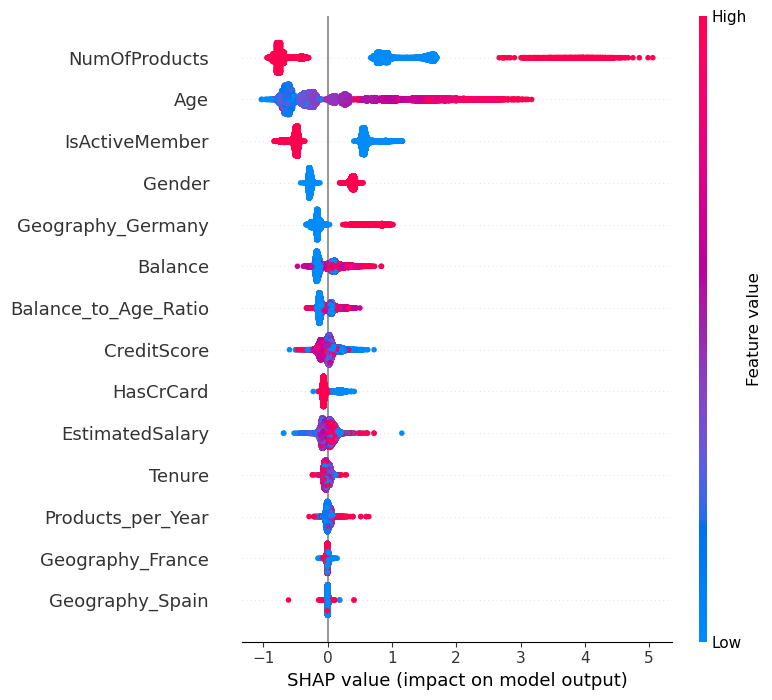

Generating SHAP bar plot:


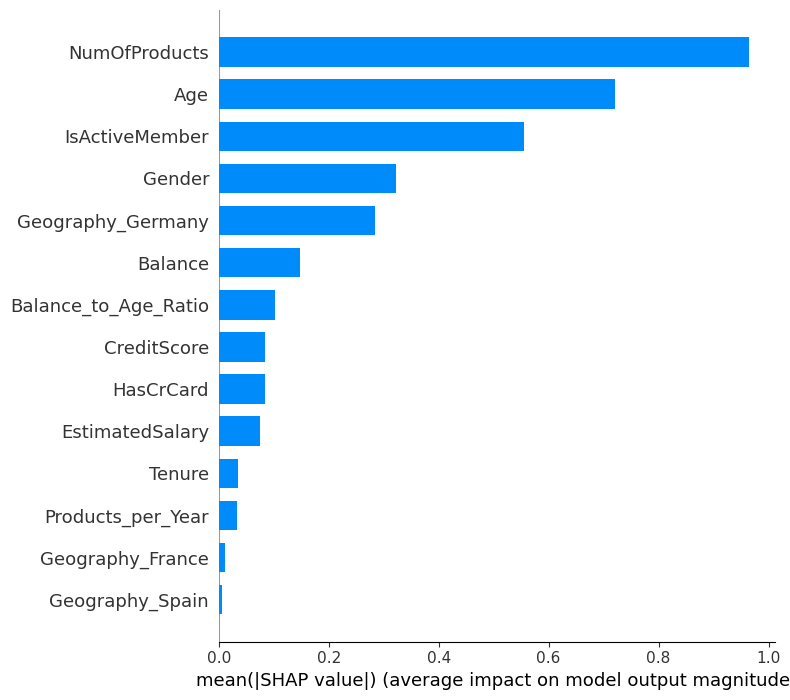

Generating SHAP dependence plot for Balance_to_Age_Ratio...


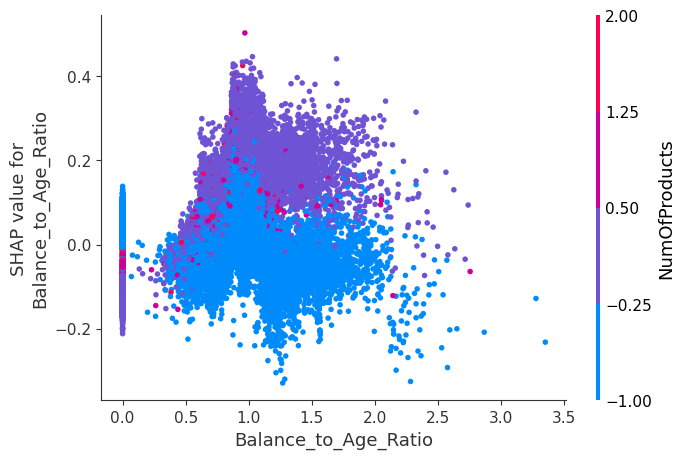

In [83]:
# Select the best model for SHAP analysis (CatBoost or RandomForest)
if isinstance(best_final_model, CatBoostClassifier):
    print("Using CatBoost model for SHAP analysis...")
    explainer = shap.TreeExplainer(best_final_model)
else:
    print("Using Random Forest model for SHAP analysis...")
    explainer = shap.TreeExplainer(best_final_model)

# Calculate SHAP values for the validation set
shap_values = explainer.shap_values(X_val)

# Summary Plot (Feature Importance Overview)
print("Generating SHAP summary plot...")
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_val, feature_names=X.columns)
plt.show()

# Bar Plot for Global Feature Importance
print("Generating SHAP bar plot:")
shap.summary_plot(shap_values, X_val, plot_type="bar", feature_names=X.columns)
plt.show()

# SHAP Dependence Plot for a Key Feature
key_feature = "Balance_to_Age_Ratio"  
print(f"Generating SHAP dependence plot for {key_feature}...")
shap.dependence_plot(key_feature, shap_values, X_val, feature_names=X.columns)
